The following code is adapted from my study of classifying delinquent mortgages. Here we will be studying housing turnover instead, We will consider turnover to have occurred whenever a borrower prepays on a mortgage without any refinance incentive.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
pd.options.mode.chained_assignment = None

We incorporate average interest rates, for short-term and long-term mortgages, into the dataframe. 

In [2]:
prim15 = pd.read_csv('primary15yr.txt', delimiter = '\t')
new_index = []
for date in prim15['Date']:
    new_date = date[-4:]+date[:2]
    new_index.append(new_date)
prim15 = prim15.assign(date=new_index)
prim15['date'] = prim15['date'].astype(int)
prim15 = prim15.drop('Date', axis=1)
prim15.set_index('date', inplace=True)

prim30 = pd.read_csv('primary30yr.txt', delimiter = '\t')
new_index = []
for date in prim30['Date']:
    new_date = date[-4:]+date[:2]
    new_index.append(new_date)
prim30 = prim30.assign(date=new_index)
prim30['date'] = prim30['date'].astype(int)
prim30 = prim30.drop('Date', axis=1)
prim30.set_index('date', inplace=True)

This is an index of housing prices by state. For Guam, Puerto Rico, the Virgin Islands, etc., we assume the national average. 

In [3]:
state_hpi = pd.read_csv('state_hbi.csv')
state_hpis= state_hpi.loc[312:]
state_hpis.loc[:,'Date'] = state_hpis.apply(lambda x: x.loc['Date'][3:] + x.loc['Date'][:2], axis=1)
#state_hpi_06.loc[:,'Date'] = state_hpi_06.apply(lambda x: x.loc['Date'][3:] + x.loc['Date'][:2], axis=1)
state_hpis.Date=state_hpis.Date.astype(int, copy=False)
state_hpis.set_index('Date', inplace = True)
#for loans in Guam,Puerto Rico, & the Virgin Islands, I set 'state' hpi to national levels. 

In [4]:
state_hpas = pd.DataFrame(index = state_hpis.index)
for column in state_hpis.columns:
    old = state_hpis[column]
    shifted = old.shift(1)
    new = old / shifted
    state_hpas[column] = new
state_hpas.loc[200101] = 1

In [5]:
#unzips the state hpa data
index = state_hpas.index
lyst = []
for state in state_hpas.columns:
    series1 = state_hpas[state]
    series1.name='hpa'
    series2 = pd.Series(state, index=index)
    series2.name = 'state'
    frame = pd.concat([series1, series2], axis=1)
    lyst.append(frame)
state_hpas = pd.concat(lyst)

In [6]:
#multi index magic
tuples = zip(state_hpas.index,state_hpas.state.values)
index1 = pd.MultiIndex.from_tuples(tuples, names = ['first payment date', 'property state'])
index2 = pd.MultiIndex.from_tuples(tuples, names = ['monthly reporting period', 'property state'])
s_multi_orig = pd.Series(state_hpas.hpa.values, index = index1, name='original hpa')
s_multi_mp = pd.Series(state_hpas.hpa.values, index = index2, name = 'current hpa')

In [7]:
state_uer = pd.read_csv('state_uer.csv')
months = {'JAN':1,'FEB':2,'MAR':3,'APR':4,'MAY':5,'JUN':6,'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}
state_uer['month'] = state_uer.Mnth.map(months)
state_uer['Date'] = 100*state_uer['DataYear'].values + state_uer['month'].values
state_uer.set_index('Date', inplace=True)

In [8]:
uer = pd.read_csv('UnemploymentHistory.txt', delimiter = "\t")
uer.loc[:,'Date'] = uer.apply(lambda x: x.loc['Date'][3:] + x.loc['Date'][:2], axis=1)
uer.Date = uer.Date.astype(int, copy=False)
uer.set_index('Date', inplace=True)

In [9]:
temp_index = []
for year in range(1990,2018):
    for month in range(1,13):
        mrp = year*100 + month
        temp_index.append(mrp)
        if mrp == 201705:
            break
temp_index = np.array(temp_index)

In [10]:
states = state_uer.State.unique()
state_uer_long = pd.DataFrame(index = temp_index, columns = states)
for mrp in temp_index:
    mrp_slice = state_uer.loc[mrp]
    for state in states:
        state_slice = mrp_slice.loc[mrp_slice['State']==state]
        state_uer_long.loc[mrp,state] = state_slice.UnemploymentRate.values[0]

In [11]:
us_colonies = ['VI','PR','GU']
for colony in us_colonies:
    state_uer_long[colony] = uer['Unemployment']       

In [12]:
index = state_uer_long.index
lyst = []
for state in state_uer_long.columns:
    series1 = state_uer_long[state]
    series1.name='uer'
    series2 = pd.Series(state, index=index)
    series2.name = 'state'
    frame = pd.concat([series1, series2], axis=1)
    lyst.append(frame)
state_uer = pd.concat(lyst)

In [13]:
tuples = zip(state_uer.index,state_uer.state.values)
index1 = pd.MultiIndex.from_tuples(tuples,names = ['monthly reporting period','property state'])
u_multi = pd.Series(state_uer.uer.values,index=index1,name='unemployment')

In [14]:
hpi_and_uer = pd.concat([s_multi_mp,u_multi], axis=1)

National unemployment rate. 

In [15]:
def cleaner(year):
    odf = pd.read_csv('samples/sample_orig_%i.txt'%year, delimiter = '|', header = None, na_values='   ', 
                      usecols = [0,1,8,10,16,18,19,20,21], names = ['credit score','first payment date','original cltv','original upb', 'property state','postal code', 'loan sequence number', 'loan purpose','original loan term'])
    odf['>300?'] = np.where(odf['original loan term']>300, True, False)
    odf = odf.join(s_multi_orig, how='left', on=['first payment date', 'property state'])
    mpdf = pd.read_csv('samples/sample_svcg_%i.txt'%year, delimiter = '|', header = None, usecols = [0,1,2,3,4,8,10], 
                       na_values =['R','XX', '   ', '  '], names = ['loan sequence number', 'monthly reporting period', 'current actual upb', 'current loan delinquency status','loan age', 'zero balance code','current interest rate'])
    mpdf = mpdf.assign(zbc_lead = mpdf['zero balance code'].shift(-1))
    mpdf = mpdf.assign(terminated = mpdf['zbc_lead'].isin([1.0]))
    #filtering out prepayment
    mpdf = mpdf.loc[mpdf['current loan delinquency status'].isin([0,1])]
    #this step restricts our consideration to current loans
    df = mpdf.join(odf.set_index('loan sequence number'), on=('loan sequence number'), how='left')
    longs = df.loc[df['>300?']]
    longs = longs.merge(prim30, how='left', left_on='monthly reporting period', right_index=True)
    shorts = df.loc[~df['>300?']]
    shorts = shorts.merge(prim15, how='left', left_on='monthly reporting period', right_index=True)
    df = pd.concat([longs, shorts])
    df = df.join(s_multi_mp, how='left', on=['monthly reporting period', 'property state'])
    df = df.join(u_multi, how='left', on=['monthly reporting period', 'property state'])
    zero_balance_loans = np.where(df['zero balance code'].notnull())[0]
    df['coupon ratio'] = df['current interest rate'].values / df['Rate (Avg)'].values
    a = len(df)
    df = df.loc[df['coupon ratio'] < 1]
    #weeding out the loans with refi incentive
    b = len(df)
    display('keeping ' + str(b) +' out of ' + str(a) + " entries")
    return df

In [16]:
#my variable naming is VIRTUOSTIC
liszt = []
for i in range(2005,2013):
    frame = cleaner(i)
    liszt.append(frame)

'keeping 1597939 out of 3470520 entries'

'keeping 629565 out of 2761607 entries'

'keeping 411435 out of 2526226 entries'

'keeping 233719 out of 2101131 entries'

'keeping 483951 out of 2491037 entries'

'keeping 323648 out of 2381515 entries'

'keeping 301487 out of 2157578 entries'

'keeping 1266637 out of 2140780 entries'

In [17]:
monthly_percent_turnover_by_vintage = {}
for i in range(8):
    year = 2005+i
    rate = liszt[i].terminated.astype(int).mean()
    a_rate = rate*100
    monthly_percent_turnover_by_vintage[year] = a_rate
monthly_percent_turnover_by_vintage

{2005: 0.616544185979565,
 2006: 0.4995512774693638,
 2007: 0.33030733894782893,
 2008: 0.2870968984121959,
 2009: 0.3051961872173009,
 2010: 0.35779612418429896,
 2011: 0.5230739633881394,
 2012: 0.5115909293665036}

In [18]:
df = pd.concat(liszt)

In [19]:
df['present year'] = df['monthly reporting period'].values/100

In [20]:
df['present year'].value_counts()

2007    911296
2008    843064
2006    659390
2014    616683
2013    511761
2015    379086
2011    365424
2010    284871
2009    219223
2005    196145
2016    159569
2012    101869
Name: present year, dtype: int64

Let's take a look at what the dataframe looks like. 

In [21]:
df.head()

,loan sequence number,monthly reporting period,current actual upb,current loan delinquency status,loan age,zero balance code,current interest rate,zbc_lead,terminated,credit score,...,postal code,loan purpose,original loan term,>300?,original hpa,Rate (Avg),current hpa,unemployment,coupon ratio,present year
0,F105Q1000064,200503,62000.0,0.0,0,NaN,5.75,NaN,False,722.0,...,98200.0,P,360,True,1.02052,6.105,1.020950,6,0.941851,2005
1,F105Q1000064,200504,62000.0,0.0,1,NaN,5.75,NaN,False,722.0,...,98200.0,P,360,True,1.02052,6.010,1.020520,5.5,0.956739,2005
2,F105Q1000064,200505,62000.0,0.0,2,NaN,5.75,NaN,False,722.0,...,98200.0,P,360,True,1.02052,5.870,1.020107,5.4,0.979557,2005
4,F105Q1000064,200507,62000.0,0.0,4,NaN,5.75,NaN,False,722.0,...,98200.0,P,360,True,1.02052,5.833,1.017078,5.3,0.985771,2005
5,F105Q1000064,200508,62000.0,0.0,5,NaN,5.75,NaN,False,722.0,...,98200.0,P,360,True,1.02052,5.953,1.016791,5.3,0.965900,2005


In [22]:
len(df)

5248381

Restricting our attention to loans with no refinance incentive considerably reduces the size of the problem: from roughly 20 mil datapoints down to about 5 million.  

In [23]:
df.columns

Index([u'loan sequence number', u'monthly reporting period',
       u'current actual upb', u'current loan delinquency status', u'loan age',
       u'zero balance code', u'current interest rate', u'zbc_lead',
       u'terminated', u'credit score', u'first payment date', u'original cltv',
       u'original upb', u'property state', u'postal code', u'loan purpose',
       u'original loan term', u'>300?', u'original hpa', u'Rate (Avg)',
       u'current hpa', u'unemployment', u'coupon ratio', u'present year'],
      dtype='object')

The avg. yearly turnover rates by year.

In [24]:
turnover_percent_per_annum = []
for i in range(2005, 2017):
    slyce = df.loc[df['present year']==i]
    rate = slyce.terminated.astype(int).mean()
    a_rate = 100*(1-(1-rate)**12)
    turnover_percent_per_annum.append(a_rate)
annum_key = {}
for i in range(0,12):
    year = 2005+i
    annum_key[year] = turnover_percent_per_annum[i]
annum_key

{2005: 4.891253924128424,
 2006: 6.702153903628815,
 2007: 6.888456795228215,
 2008: 5.947685136453162,
 2009: 2.948134628989585,
 2010: 3.4612270738941686,
 2011: 3.3527083313217076,
 2012: 2.2499665967154248,
 2013: 5.1121906305779845,
 2014: 5.811170568218349,
 2015: 7.624114625797141,
 2016: 7.189164633376032}

Note: By multiplying the quarterly probability of delinquency by 3, we obtain a (rather good) estimate of the quarterly rate 'proper' (analogous to the compound interest calculation).  

In [25]:
import matplotlib.pyplot as plt

In [26]:
turnover_percent_per_quarter = []
for i in range(2005, 2017):
    l = []
    for j in range(1,13):
        mrp = 100*i + j
        slyce = df.loc[df['monthly reporting period']==mrp]
        rate = slyce.terminated.astype(int).mean()
        a_rate = 100*rate
        l.append(a_rate)
    for k in range(0,4):
        b = 3*k
        q_rate = 3*(np.mean(l[b:b+3]))
        turnover_percent_per_quarter.append(q_rate)

In [27]:
quarter_key = {}
for i in range(12):
    year = str(i + 2005)
    for j in range(4):
        quarter = 'Q' + str(j+1)
        index = i+j
        name = year+quarter
        quarter_key[name] = turnover_percent_per_quarter[i+j]    

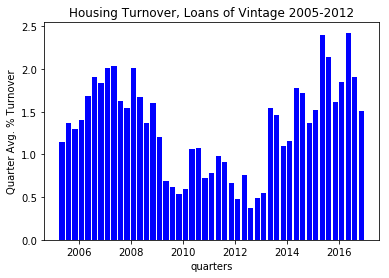

In [28]:
a_ran = np.arange(2005,2017,0.25)
plt.bar(a_ran, turnover_percent_per_quarter, color='b', align='edge', width=0.2)
plt.ylabel('Quarter Avg. % Turnover')
plt.title('Housing Turnover, Loans of Vintage 2005-2012')
plt.xlabel('quarters')
plt.show()

People weren't in a rush to move while the economy was struggling. 

We plot out some macroeconomic trends. 

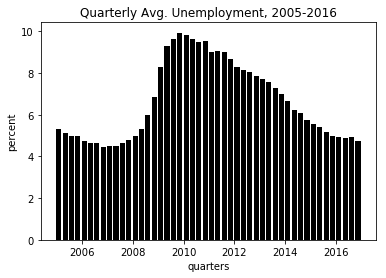

In [29]:
quarter_avg_uer = []
for i in range(2005, 2017):
    l = []
    for j in range(1,13):
        mrp = 100*i + j
        unemp = uer.loc[mrp, 'Unemployment']
        l.append(unemp)
    for k in range(0,4):
        b = 3*k
        q_uer = (np.mean(l[b:b+3]))
        quarter_avg_uer.append(q_uer)
a_ran = np.arange(2005,2017,0.25)
plt.bar(a_ran, quarter_avg_uer, color='k', align='edge', width=0.2)
plt.title('Quarterly Avg. Unemployment, 2005-2016')
plt.ylabel('percent')
plt.xlabel('quarters')
plt.show()

Looks like an inverse relationship between unemployment and turnover. 

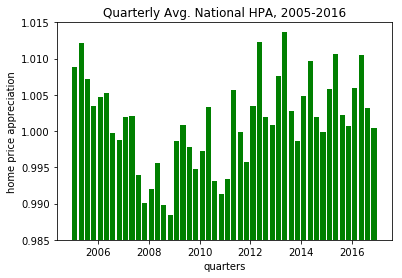

In [30]:
national_hpa = state_hpas.loc[state_hpas.state=='VI']
quarter_avg_hpa = []
for i in range(2005, 2017):
    l = []
    for j in range(1,13):
        mrp = 100*i + j
        hpa = national_hpa.loc[mrp, 'hpa']
        l.append(hpa)
    for k in range(0,4):
        b = 3*k
        q_hpa = (np.mean(l[b:b+3]))
        quarter_avg_hpa.append(q_hpa)
a_ran = np.arange(2005,2017,0.25)
plt.bar(a_ran, quarter_avg_hpa, color='g', align='edge', width=0.2)
plt.title('Quarterly Avg. National HPA, 2005-2016')
plt.ylim(0.985,1.015)
plt.ylabel('home price appreciation')
plt.xlabel('quarters')
plt.show()

If there's any correlation between HPA and turnover, it's not obvious. 

What is the relationship between loan age and delinquency, hmm?

In [31]:
turn_by_age = []
bin_count = []
for i in range(0,100):
    age_slice = df.loc[df['loan age']==i]
    bin_count.append(len(age_slice))
    rate = age_slice.terminated.astype(int).mean()
    turn_by_age.append(rate)

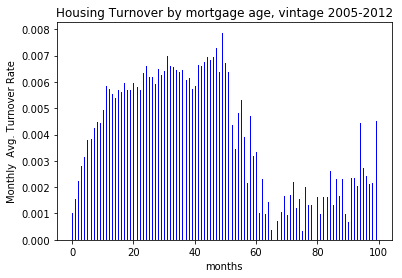

In [32]:
plt.bar(range(100), turn_by_age, color='b', align='edge', width=0.32)
plt.ylabel('Monthly  Avg. Turnover Rate')
plt.title('Housing Turnover by mortgage age, vintage 2005-2012')
plt.xlabel('months')
plt.show()

What's going on here? Loans that exceed a certain age (60+ months) will tend to date back before 2012, when interest rates began rising. Around 2012, a great number of homeowners had their rates modified to more affordable levels. It's likely that people with modified loans are less likely to move, for they'd have a harder time getting a new home loan with a history of delinquency.

A regional breakdown:

In [33]:
df['zip region'] = df['postal code'].values // 10000

In [34]:
yearly_turn_by_region = []
for i in range(10):
    yearly_turns = []
    slyce = df.loc[df['zip region']==i]
    for y in range(2005,2017):
        y_bin = slyce.loc[slyce['present year']==y]
        rate = 100*12*y_bin.terminated.astype(int).mean()
        yearly_turns.append(rate)
    yearly_turn_by_region.append(yearly_turns)

In [35]:
yearly_turn_by_region[8]

[6.207827260458839,
 9.008242836582493,
 8.89228856910647,
 6.393527148693134,
 2.41723051495274,
 3.2989362125981114,
 3.2125859333685884,
 1.8609089824645115,
 5.328370114331295,
 8.243008162719123,
 11.25925925925926,
 9.396849072434046]

In [36]:
zip_key = ["PR, NJ, & New England", "NY,PA,DE","Mid-Atlantic","South East","Near Midwest","North Plains","Central Plains","South","Rockies","Pacific"]

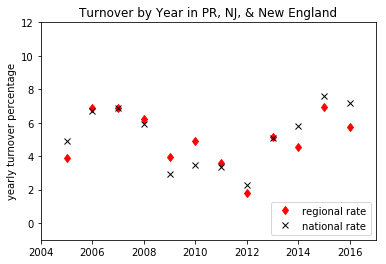

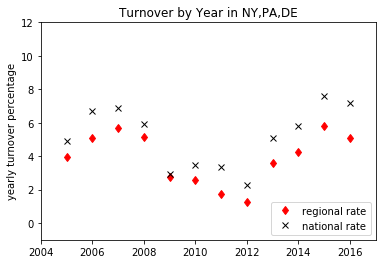

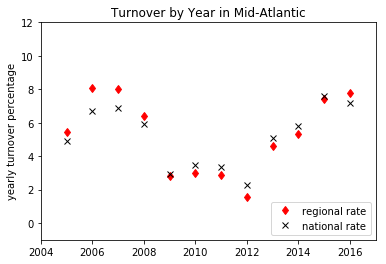

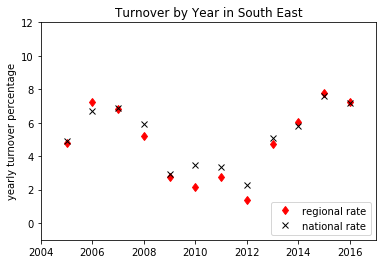

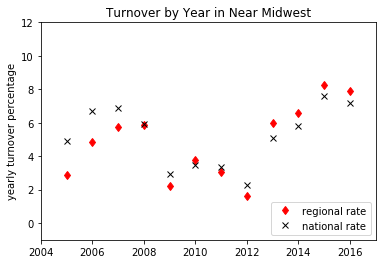

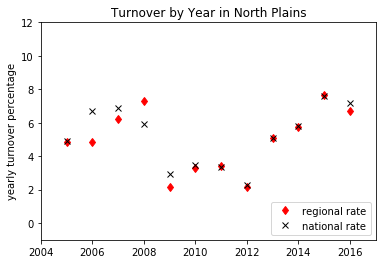

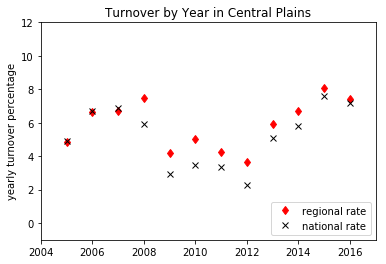

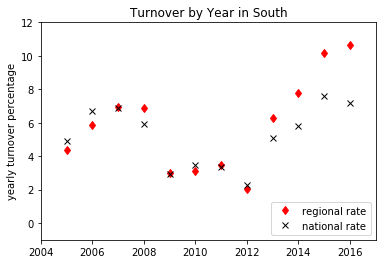

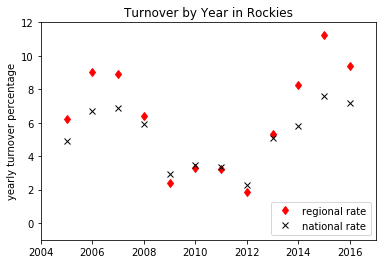

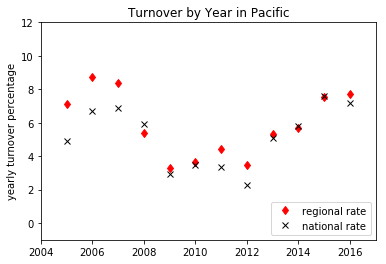

In [62]:
for i in range(10):
    plt.plot(range(2005,2017),yearly_turn_by_region[i],'rd',label='regional rate')
    plt.plot(range(2005,2017),turnover_percent_per_annum,'kx',label='national rate')
    plt.title('Turnover by Year in '+zip_key[i])
    plt.xlim(2004,2017)
    plt.ylim(-1,12)
    plt.legend(loc=4)
    plt.ylabel('yearly turnover percentage')
    plt.show()

Some considerable variation by region, it would seem. Let's focus on the Rocky Mountains: in 2015 they attain a turnover rate of ~11%. Could it be the effect of Colorado legalizing marijuana? 

In [37]:
df['factor'] = df['current actual upb'].values/df['original upb'].values

In [38]:
df['coupon ratio'] = df['current interest rate'].values/df['Rate (Avg)'].values

In [39]:
len(df)

5248381

In [40]:
df['month'] = df['monthly reporting period'].values % 100

It's a good idea to get rid of loans with a low factor--it doesn't really count as turnover if people are terminating a mortgage with little left to terminate. 

In [41]:
df = df.loc[df['factor'] > 0.2]
df_sample = df

Let's do a knock-out test, guv

In [98]:
#features = ['loan age', 'credit score', 'original upb','unemployment', 'postal code', 'original cltv', 'month', 'factor', 'current hpa']
features = ['loan age', 'unemployment', 'factor', 'month']
df_train = df_sample.sample(frac = 0.8, random_state = 89)
df_test = df_sample.drop(df_train.index)
X_train = df_train[features]
y_train = df_train['terminated'].astype(int)
X_test = df_test[features]
y_test = df_test['terminated'].astype(int)

In [99]:
from sklearn.preprocessing import Imputer
imp = Imputer()
imp.fit(X_train)
X_train = imp.transform(X_train)

imp = Imputer()
imp.fit(X_test)
X_test = imp.transform(X_test)

In [100]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 20, min_samples_leaf = 15000)
#n_estimators = 40, min_samples_leaf = 25000, max_leaf_nodes=120, max_depth=15, n_jobs=-1
rf.fit(X_train, y_train)

#max_leaf_nodes=20, min_samples_leaf=3000

from sklearn import metrics
y_train_score = rf.predict_proba(X_train)[:,1]
y_test_score = rf.predict_proba(X_test)[:,1]
display('Random Forest training set auc vs test set auc is', metrics.roc_auc_score(y_train, y_train_score), metrics.roc_auc_score(y_test, y_test_score))

'Random Forest training set auc vs test set auc is'

0.64144768872389579

0.64084855152392184

In practice, finding the optimal RF parameters takes some trial-and-error work. To my knowledge, there's no formula out there. 

In [101]:
d = {}
for i in range(len(features)):
    d[features[i]] = rf.feature_importances_[i]
d

{'factor': 0.28757594626400301,
 'loan age': 0.36214710532572836,
 'month': 0.11523428323242042,
 'unemployment': 0.23504266517784825}

I plot, for each feature, separated into 20 bins, the actual probability (frequency) of delinquency and estimated probabilities on the training and test sets. 

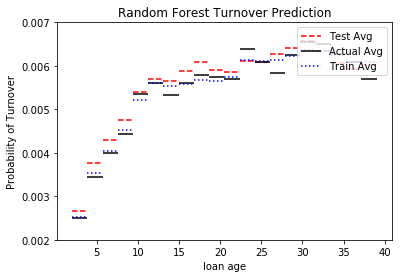

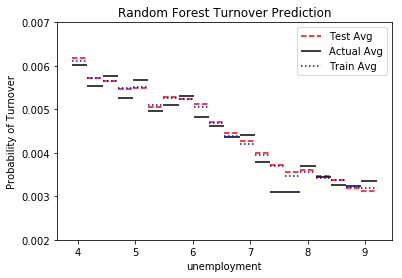

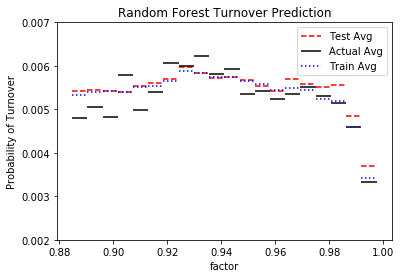

/home/nikku/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/home/nikku/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


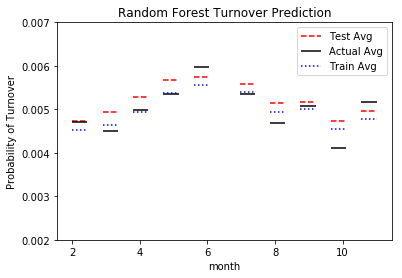

In [102]:
for feature in features:
    floor = df[feature].quantile(0.1)
    ceiling = df[feature].quantile(0.9)
    a = np.linspace(floor, ceiling, 21)
    
    test = df_test[[feature, 'terminated']]
    test['probs'] = rf.predict_proba(X_test)[:,1]
    
    train = df_train[[feature, 'terminated']]
    train['probs'] = rf.predict_proba(X_train)[:,1]
    
    sample = df_sample[[feature, 'terminated']]
    
    def test_prob():
        l = []
        for i in range(len(a) - 1):
            lower = a[i]
            upper = a[i+1]
            bin_i = test.loc[test[feature].between(lower,upper)]
            avg = (bin_i['probs'].values.sum())/len(bin_i['probs'].values)
            l.append(avg)
        return l
    
    def train_prob():
        l = []
        for i in range(len(a) - 1):
            lower = a[i]
            upper = a[i+1]
            bin_i = train.loc[train[feature].between(lower,upper)]
            avg = (bin_i['probs'].values.sum())/len(bin_i['probs'].values)
            l.append(avg)
        return l
    
    def true_prob():
        l = []
        for i in range(len(a)-1):
            lower = a[i]
            upper = a[i+1]
            bin_i = sample.loc[sample[feature].between(lower,upper)]
            s = bin_i['terminated'].astype(int).mean()
            l.append(s)
        return l
    
    plt.hlines(test_prob(), a[:-1], a[1:], color = 'r', linestyle = "--", label = "Test Avg" )
    plt.hlines(true_prob(), a[:-1], a[1:], label = "Actual Avg")
    plt.hlines(train_prob(),a[:-1], a[1:], color = 'b', linestyle = ':', label = 'Train Avg' )
    plt.legend(loc = 1)
    plt.xlabel(feature)
    plt.title('Random Forest Turnover Prediction')
    plt.ylabel('Probability of Turnover')
    plt.ylim(0.002,0.007)
    plt.show()  

How does a logistic regression (with no feature engineering) perform?

In [57]:
import sklearn.linear_model as lr
logit = lr.LogisticRegression()

logit.fit(X = X_train, y = y_train)

display('logit coefficients are: ', logit.coef_)

'logit coefficients are: '

array([[ -1.50650013e-04,  -7.09436777e-03,  -4.25945988e-07,
         -6.24792877e-05,   1.00351678e-06,  -6.23122963e-04,
         -6.80843888e-05,  -9.75075430e-06,  -9.93975594e-06]])

In [58]:
y_train_score = logit.predict_proba(X_train)[:,1]
y_test_score = logit.predict_proba(X_test)[:,1]
display('Logistic regression training set auc vs test set auc is', metrics.roc_auc_score(y_train, y_train_score), metrics.roc_auc_score(y_test, y_test_score))

'Logistic regression training set auc vs test set auc is'

0.52873862150169948

0.52797366983974237

As it turns out, not as well. In fact, an AUC this low means that the logistic regression is performing about as well as random guessing would. 

I make the same three-way comparison graph for logistic-estimated and actual turnover probabilities. 

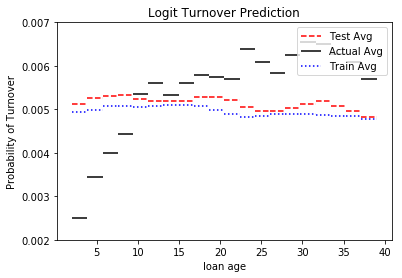

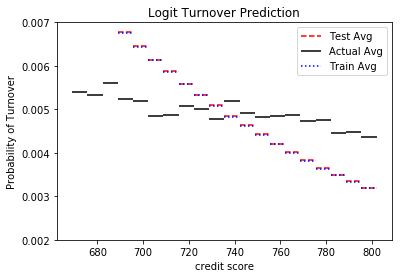

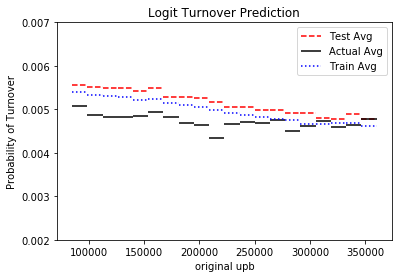

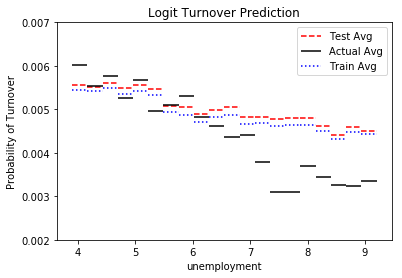

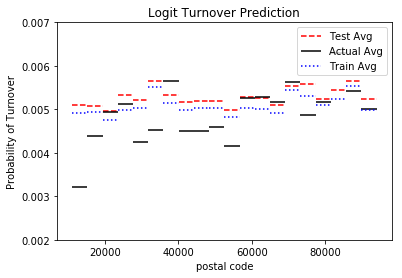

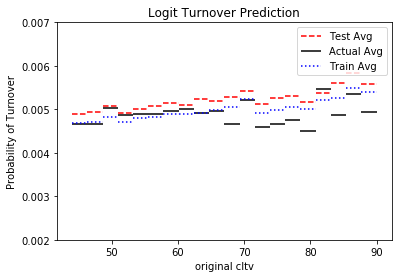

/home/nikku/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/home/nikku/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


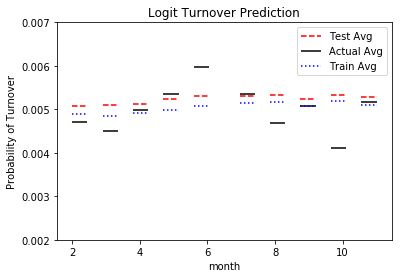

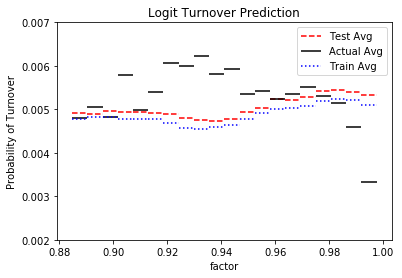

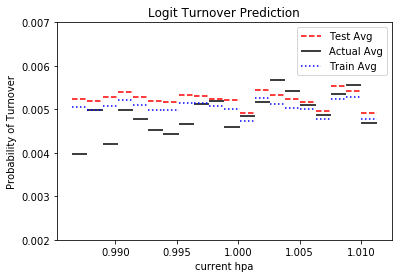

In [59]:
for feature in features:
    floor = df[feature].quantile(0.1)
    ceiling = df[feature].quantile(0.9)
    a = np.linspace(floor, ceiling, 21)
    
    test = df_test[[feature, 'terminated']]
    test['probs'] = logit.predict_proba(X_test)[:,1]
    
    train = df_train[[feature, 'terminated']]
    train['probs'] = logit.predict_proba(X_train)[:,1]
    
    sample = df_sample[[feature, 'terminated']]
    
    def test_prob():
        l = []
        for i in range(len(a) - 1):
            lower = a[i]
            upper = a[i+1]
            bin_i = test.loc[test[feature].between(lower,upper)]
            avg = (bin_i['probs'].values.sum())/len(bin_i['probs'].values)
            l.append(avg)
        return l
    
    def train_prob():
        l = []
        for i in range(len(a) - 1):
            lower = a[i]
            upper = a[i+1]
            bin_i = train.loc[train[feature].between(lower,upper)]
            avg = (bin_i['probs'].values.sum())/len(bin_i['probs'].values)
            l.append(avg)
        return l
    
    def true_prob():
        l = []
        for i in range(len(a)-1):
            lower = a[i]
            upper = a[i+1]
            bin_i = sample.loc[sample[feature].between(lower,upper)]
            s = bin_i['terminated'].astype(int).mean()
            l.append(s)
        return l
    
    plt.hlines(test_prob(), a[:-1], a[1:], color = 'r', linestyle = "--", label = "Test Avg" )
    plt.hlines(true_prob(), a[:-1], a[1:], label = "Actual Avg")
    plt.hlines(train_prob(),a[:-1], a[1:], color = 'b', linestyle = ':', label = 'Train Avg' )
    plt.legend(loc = 1)
    plt.xlabel(feature)
    plt.title('Logit Turnover Prediction')
    plt.ylabel('Probability of Turnover')
    plt.ylim(0.002,0.007)
    plt.show()  


  

We see a few instances of where the actual probabilties respond non-linearly to the input variables. The logistic regression doesn't seem to fit very well. 